In [2]:
import numpy as np 
import awkward as ak
import sys
sys.path.append("..")
from binary_decoders import lecroy
from oscilliscope_fitting import mcp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import importlib
from scipy import interpolate
import uproot
from hist import Hist
import mplhep


# FAILURES

# 21, 57, 4999

1e-10
-2.5077467087343622e-08
5000
4994


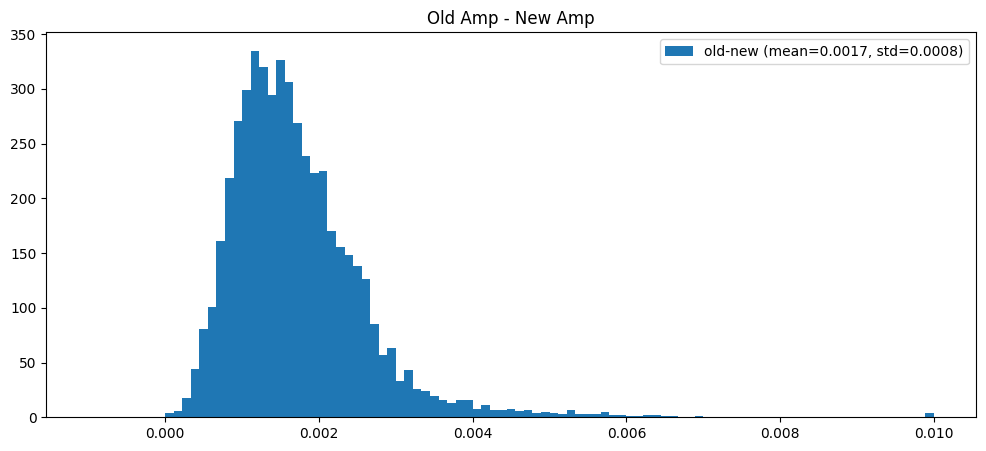

In [68]:
importlib.reload(mcp)
importlib.reload(lecroy)
old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
nano_times = conv_old.time[:,0]*1e9

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(nano_times, mcp_data.y)

# Plot histograms
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
d = old_amp - peak_ys

print(len(d))
print(len(d[np.isfinite(d)]))
mean_diff = np.mean(d[np.isfinite(d)])
std_diff = np.std(d[np.isfinite(d)])
bins = np.linspace(-0.001, 0.01, 100)
plt.hist(np.clip(old_amp-peak_ys, bins[0], bins[-1]), 
         bins=bins,  
         label=f"old-new (mean={mean_diff:.4f}, std={std_diff:.4f})")
axs.set_title('Old Amp - New Amp')
plt.legend()


1e-10
-2.5077467087343622e-08
-1.0332693
-0.0012817272984513614
5000
4995


/home/users/hswanson13/ETL_TestingDAQ/notebooks/../oscilliscope_fitting/mcp.py:54: RuntimeWarning: divide by zero encountered in divide
  return -B/(2*A), C - B**2/(4*A) #-> x_interpolated_peak, y_interpolated_peak
/home/users/hswanson13/ETL_TestingDAQ/notebooks/../oscilliscope_fitting/mcp.py:54: RuntimeWarning: invalid value encountered in divide
  return -B/(2*A), C - B**2/(4*A) #-> x_interpolated_peak, y_interpolated_peak


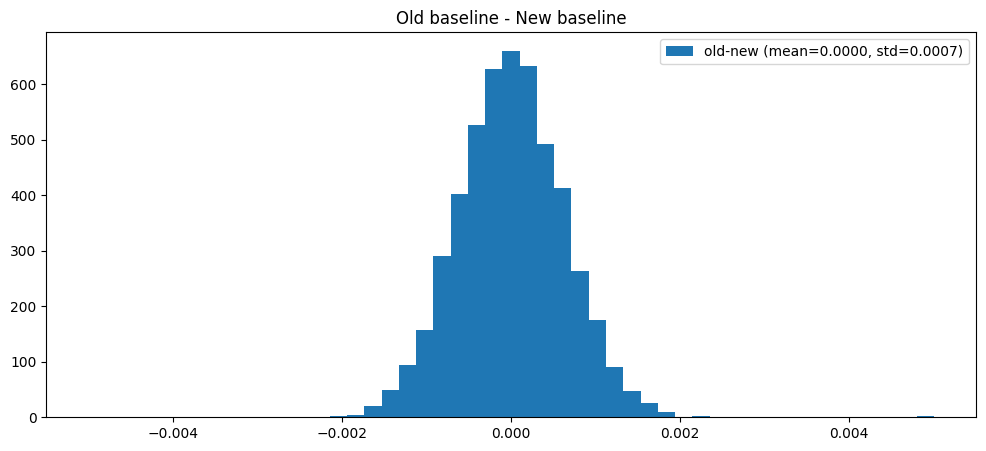

In [72]:
importlib.reload(mcp)
old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000
old_baseline = old.baseline[:,1]/1000
old_baseline_RMS = old.baseline_RMS[:,1]

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
nanoseconds = mcp.MCPSignalScaler._center_array(mcp_data.x*1e9)

peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(nanoseconds, mcp_data.y)
baselines = mcp.MCPSignalScaler._calc_baselines(nanoseconds, mcp_data.y, peak_xs, peak_ys)

# Plot histograms
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

d = old_baseline - baselines
print(old.baseline[:,1][0])
print(baselines[0])
print(len(d))
print(len(d[np.isfinite(d)]))
mean_diff = np.mean(d[np.isfinite(d)])
std_diff = np.std(d[np.isfinite(d)])

bins = np.linspace(-0.005, 0.005, 50)
plt.hist(np.clip(old_baseline-baselines, bins[0], bins[-1]), 
         bins=bins,  
         label=f"old-new (mean={mean_diff:.4f}, std={std_diff:.4f})")

axs.set_title('Old baseline - New baseline')
plt.legend()


5000


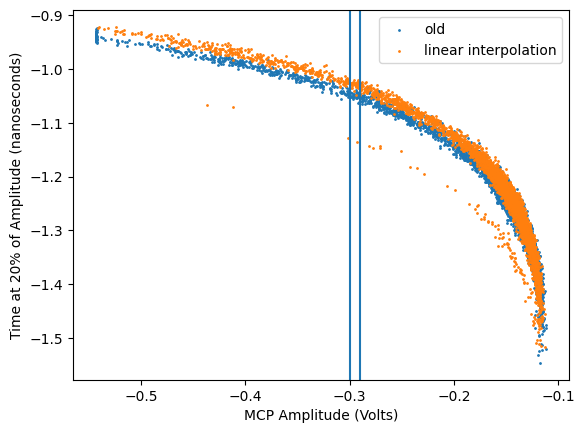

In [27]:
def linear_interpolation(x, y, peak_xs, plot_idx=None):
    rising_volts_mask = x < peak_xs[:, np.newaxis]
    rising_ns = np.where(rising_volts_mask, x, np.NaN)
    rising_v = np.where(rising_volts_mask, y, np.NaN)

    time_of_threshold = []
    for i in range(len(rising_ns)):
        try:
            lin_interp = interpolate.interp1d(rising_v[i], rising_ns[i])
            time_of_threshold.append(lin_interp(0.2))
            if plot_idx == i:
                mask = rising_ns[i] > -5
                plt.plot(rising_ns[i][mask], rising_v[i][mask], marker='.')
                plt.axvline(lin_interp(0.2), color='red')
                plt.axvspan(lin_interp(0.2)-0.05, lin_interp(0.2)+0.05, facecolor='red', alpha=0.5)
                plt.axhline(0.2, color='black', linestyle='--')
                break
        except ValueError:
            time_of_threshold.append(0)
            print(f"Broken Interpolation! on {i}")
            mask = rising_ns[i] > -5
            plt.plot(rising_ns[i][mask], rising_v[i][mask], marker='.')
            break
    return np.array(time_of_threshold)

ref_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C3--Trace5100.trc")
_, chorz = ref_data.segment_times


importlib.reload(mcp)
importlib.reload(lecroy)
old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000
old_baseline = old.baseline[:,1]/1000
old_baseline_RMS = old.baseline_RMS[:,1]
old_toff = old.timeoffsets[:,1]*1e9
old_toff = old_toff.to_numpy()

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
# nano_times = conv_old.time[:,0]*1e9
# nano_times = nano_times.to_numpy()

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
_, horz_off = mcp_data.segment_times
scaled_s, scaled_v = mcp.MCPSignalScaler.normalize(mcp_data.x*1e9, mcp_data.y)
peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(scaled_s, mcp_data.y)

plt.scatter(old_amp, old_lp2*10**9, s=1, label="old")

# # 2. Linear interpolation

toff = (chorz - horz_off)*1e9
time_L20 = linear_interpolation(scaled_s, scaled_v, peak_xs) #-old_toff[:,np.newaxis]

print(len(time_L20))
# good_fits = (time_L20 != 0) & (time_L20 > -3)
plt.scatter(peak_ys, time_L20, s=1, label="linear interpolation")

plt.xlabel("MCP Amplitude (Volts)")
plt.ylabel("Time at 20% of Amplitude (nanoseconds)")
plt.legend()

plt.axvline(-0.3)
plt.axvline(-0.29)

1e-10
-2.5077467087343622e-08
-----------
-0.085999995
0.0139999995


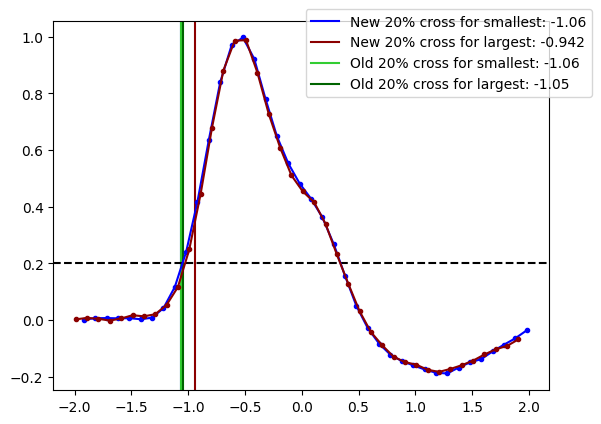

In [43]:
# Investigation of large signals
importlib.reload(mcp)
from scipy import interpolate

def linear_interpolation(x, y, peak_xs):
    rising_volts_mask = x < peak_xs[:, np.newaxis]
    rising_ns = np.where(rising_volts_mask, x, np.NaN)
    rising_v = np.where(rising_volts_mask, y, np.NaN)

    time_of_threshold = []
    for rv, rs in zip(rising_v, rising_ns):
        try:
            lin_interp = interpolate.interp1d(rv, rs)
            time_of_threshold.append(lin_interp(0.2))
        except ValueError:
            time_of_threshold.append(0)
    return np.array(time_of_threshold)

old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000
old_baseline = old.baseline[:,1]/1000
old_toff = old.timeoffsets[:,1]*1e9

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
nano_times = conv_old.time[:,0]*1e9

# big_peak_mask = (old_amp > -0.3) & (old_amp <-0.29)

## Large Amplitudes
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
nano, volts = mcp.MCPSignalScaler.normalize(nano_times.to_numpy(), mcp_data.y)
peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(nano, mcp_data.y)
baselines = mcp.MCPSignalScaler._calc_baselines(nano, mcp_data.y, peak_xs, peak_ys)

big_peak_mask = (peak_ys > -0.3) & (peak_ys <-0.29)
big_ns = nano[big_peak_mask]
big_v = volts[big_peak_mask]
old_big_amps = old_amp[big_peak_mask]
big_baselines = baselines[big_peak_mask]
big_peak_ys = peak_ys[big_peak_mask]
big_ys = mcp_data.y[big_peak_mask]
big_toff = old_toff[big_peak_mask]

time_L20 = linear_interpolation(big_ns, big_v, peak_xs[big_peak_mask])

plt.axvline(time_L20[np.argmin(time_L20)], label=f'New 20% cross for smallest: {time_L20[np.argmin(time_L20)]:.3}', color='blue')
plt.axvline(time_L20[np.argmax(time_L20)], label=f'New 20% cross for largest: {time_L20[np.argmax(time_L20)]:.3}', color='darkred')

plt.axvline(old_lp2[big_peak_mask][np.argmin(time_L20)]*1e9, label=f'Old 20% cross for smallest: {old_lp2[big_peak_mask][np.argmin(time_L20)]*1e9:.3}', color='limegreen')
plt.axvline(old_lp2[big_peak_mask][np.argmax(time_L20)]*1e9, label=f'Old 20% cross for largest: {old_lp2[big_peak_mask][np.argmax(time_L20)]*1e9:.3}', color='darkgreen')

plt.axhline(0.2, color="black", linestyle='--')
i_plot = 0 #argmin
view_window = (big_ns[i_plot] < 2) & (big_ns[i_plot] > -2)

plt.plot(big_ns[np.argmin(time_L20)][view_window] + big_toff[np.argmin(time_L20)], 
         big_v[np.argmin(time_L20)][view_window], marker='.', color='blue')
plt.plot(big_ns[np.argmax(time_L20)][view_window] + big_toff[np.argmax(time_L20)], 
         big_v[np.argmax(time_L20)][view_window], marker='.', color='darkred')

print('-----------')
print(big_toff[np.argmax(time_L20)])
print(big_toff[np.argmin(time_L20)])

plt.legend(bbox_to_anchor=(1.1, 1.05))

# plt.clf()

# plt.plot(big_ns[np.argmin(time_L20)][view_window], 
#          big_ys[np.argmin(time_L20)][view_window], marker='.', color='blue')
# plt.plot(big_ns[np.argmax(time_L20)][view_window], 
#          big_ys[np.argmax(time_L20)][view_window], marker='.', color='darkred')

# x_center = np.take(big_ns[np.argmax(time_L20)], big_ns[np.argmax(time_L20)].size // 2)
# y_center = np.take(big_ys[np.argmax(time_L20)], big_ys[np.argmax(time_L20)].size // 2)
# plt.scatter(x_center, y_center, s=80, facecolors='none', edgecolors='r')


2.2543247781435845e-11


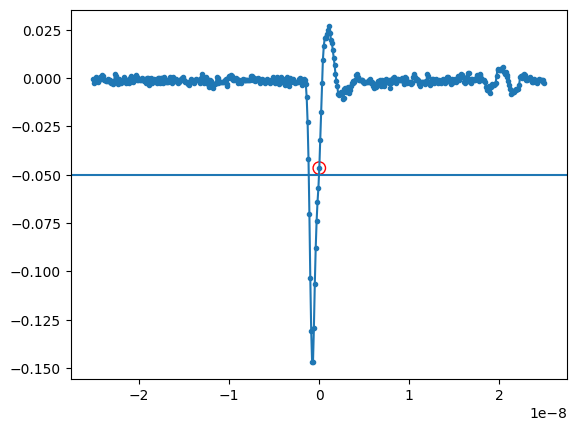

In [ ]:
#calc absolute threshold offset
importlib.reload(lecroy)
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
nano = np.array([np.arange(-25, 25+0.2, 0.1) for i in range(len(mcp_data.x))])


for i in range(1):
    plt.plot(mcp_data.x[i], mcp_data.y[i], marker='.')

    x_center = np.take(mcp_data.x[i], mcp_data.x[i].size // 2)
    y_center = np.take(mcp_data.y[i], mcp_data.x[i].size // 2)

    print(x_center)
    plt.scatter(x_center, y_center, s=80, facecolors='none', edgecolors='r')
    plt.axhline(-0.05)
    

# conv_run = uproot.open("/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
# conv_run.type.show()

# print(conv_run.time[0])

# print(y)

In [221]:
# make an array with center value 5 and lenghth 10, step 1

y = np.arange(0,11)
print(y)

center = np.take(y, y.size // 2)

def generate_centered_array(arr:np.ndarray):
    half_size = arr.size // 2
    steps = np.diff(arr)
    step_size = steps[0]
    return np.arange(
        -half_size*step_size, 
        half_size*step_size + (arr.size % 2)*step_size, 
        step_size
    )

scaled_x = np.array([generate_centered_array(x) for x in mcp_data.x])
print(scaled_x)


[ 0  1  2  3  4  5  6  7  8  9 10]
[[-2.51000103e-08 -2.50000103e-08 -2.49000103e-08 ...  2.48000102e-08
   2.49000103e-08  2.50000103e-08]
 [-2.51000103e-08 -2.50000103e-08 -2.49000103e-08 ...  2.48000102e-08
   2.49000103e-08  2.50000103e-08]
 [-2.51000103e-08 -2.50000103e-08 -2.49000103e-08 ...  2.48000102e-08
   2.49000103e-08  2.50000103e-08]
 ...
 [-2.51000103e-08 -2.50000103e-08 -2.49000103e-08 ...  2.48000102e-08
   2.49000103e-08  2.50000103e-08]
 [-2.51000103e-08 -2.50000103e-08 -2.49000103e-08 ...  2.48000102e-08
   2.49000103e-08  2.50000103e-08]
 [-2.51000103e-08 -2.50000103e-08 -2.49000103e-08 ...  2.48000102e-08
   2.49000103e-08  2.50000103e-08]]


nan
nan


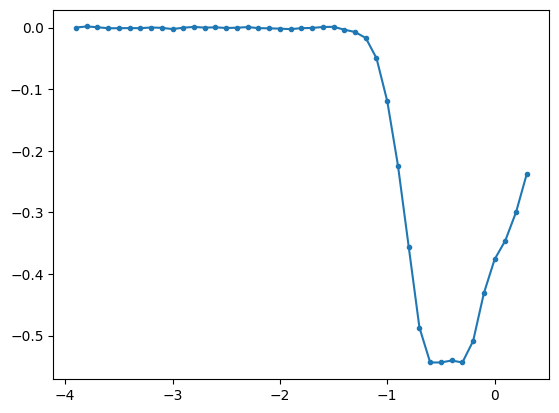

In [99]:
importlib.reload(mcp)
from scipy import interpolate

#  does lin interp cause failure? 
old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000
old_baseline = old.baseline[:,1]/1000
#old_baseline_RMS = old.baseline_RMS[:,1]/1000

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
# nanoseconds = np.array([np.arange(-25, 25+0.2, 0.1) for i in range(len(mcp_data.x))])

seconds, volts = mcp.MCPSignalScaler.normalize(mcp_data.x*1e9, mcp_data.y)
ts = mcp.MCPSignalScaler._center_array(mcp_data.x*1e9)
peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(seconds, mcp_data.y)
baselines = mcp.MCPSignalScaler._calc_baselines(seconds, mcp_data.y, peak_xs, peak_ys)
for i in range(len(seconds)):
    if i == 295:
        mask = (ts[i] < 0.4)  & (ts[i] > -4)
        plt.plot(ts[i][mask], mcp_data.y[i][mask], marker='.')
        print(baselines[i])
        print(peak_ys[i])
        plt.axhline(baselines[i])
        plt.axhline(peak_ys[i])
        plt.axvline(peak_xs[i])

        # plt.plot(seconds[i], scaled_volts)
        # plt.plot(seconds[i], volts[i])
# peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(seconds, volts)

# plt.scatter(old_amp, old_lp2*10**9, s=1, label="old")

# time_L20 = linear_interpolation(seconds, volts, old_amp)
# good_fits = (time_L20 != 0) & (time_L20 > -3)
# plt.scatter(peak_ys[good_fits], time_L20[good_fits], s=1, label="linear interpolation")



In [21]:
importlib.reload(mcp)
importlib.reload(lecroy)

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
# ts = mcp.MCPSignalScaler._center_array(mcp_data.x*1e9)

#big_signals = (np.min(mcp_data.y, axis=1) > -0.54) & (np.min(mcp_data.y, axis=1) < -0.53)

# print(np.min(mcp_data.y[big_signals]))
# print(len(mcp_data.y[big_signals]))
# for big_t, big_v in zip(mcp_data.x*1e9, mcp_data.y):
#     mask = (big_t < 2)  & (big_t > -2)
#     plt.plot(big_t[mask], big_v[mask])







# y_data = np.where(np.min(mcp_data.y, axis=1)[:,np.newaxis] > -0.54, mcp_data.y, np.NaN)
# print(y_data[295])

1e-10
-2.5077467087343622e-08


False
0.01399999994405876 0


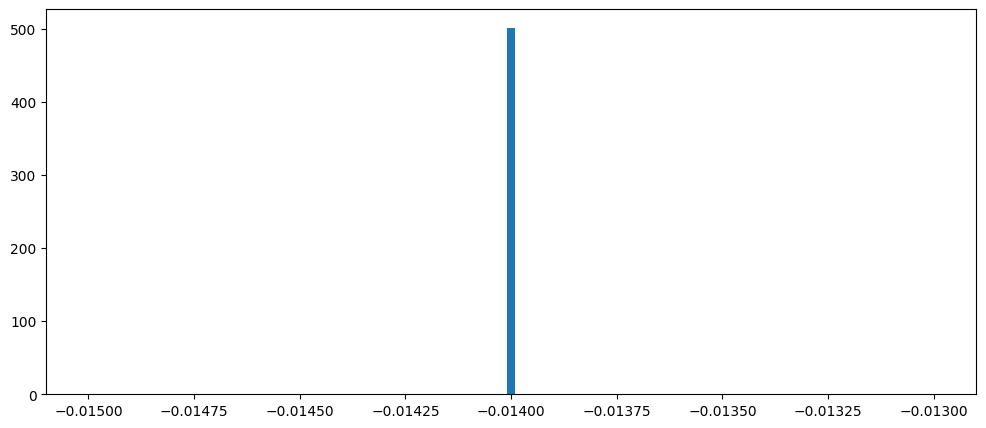

In [18]:
importlib.reload(lecroy)
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
trig_time, horz_off = mcp_data.segment_times


old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
old_times = old.time[:,0]
old_toffs = old.timeoffsets[:,1]
print(np.array_equal(mcp_data.x, old_times))
c=0
for new_x, old_x, old_toff in zip(mcp_data.x, old_times, old_toffs):
    if not np.array_equal(new_x*1e9, old_x*1e9):
        print(old_toff*1e9, c)
        fig, axs = plt.subplots(1, 1, figsize=(12, 5))
        d = (old_x - new_x)*1e9
        mean_diff = np.mean(d[np.isfinite(d)])
        std_diff = np.std(d[np.isfinite(d)])

        bins = np.linspace(-0.015, -0.013, 100)
        plt.hist(np.clip(d, bins[0], bins[-1]), 
                bins=bins,  
                label=f"old-new (mean={mean_diff:.4f}, std={std_diff:.4f})")
        break
    c+=1

1.3999999999996023e-11


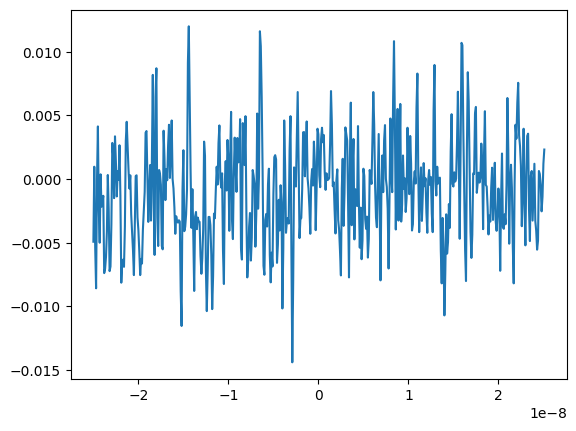

In [20]:
clock_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C1--Trace5100.trc")
_, chorz = clock_data.segment_times

toffset = horz_off - chorz
print(toffset[0])
plt.plot(clock_data.x[2], clock_data.y[2])